# **Click-Through Rate Prediction**
#### This exercise covers the steps for creating a click-through rate (CTR) prediction pipeline.  You will work with the [Criteo Labs](http://labs.criteo.com/) dataset that was used for a recent [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge).
#### ** This exercise will cover: **
+  ####*Part 1:* Parse CTR data and generate OHE features
+  ####*Part 2:* CTR prediction and logloss evaluation
 + #### *Visualization 1:* ROC curve
+  ####*Part 3:* Reduce feature dimension via feature hashing
 + #### *Visualization 2:* Hyperparameter heat map
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### **Part 1: Parse CTR data and generate 1-of-k encoding features**

#### Before we can proceed, you'll first need to obtain the data from Criteo.  If you have already completed this step in the setup lab, just run the cells below and the data will be loaded into the `rawData` variable.

In [1]:
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('HandsOnML', 'dac_sample.txt')
fileName = os.path.join(baseDir, inputPath)

if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 2)
               .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
    print rawData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### **Loading and splitting the data **
#### We are now ready to start working with the actual CTR data, and our first task involves splitting it into training, validation, and test sets.  Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets, and then [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset.

In [2]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest
print rawData.take(1)

79911 10075 10014 100000
[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [3]:
# TEST Loading and splitting the data (3a)
from test_helper import Test
Test.assertTrue(all([rawTrainData.is_cached, rawValidationData.is_cached, rawTestData.is_cached]),
                'you must cache the split data')
Test.assertEquals(nTrain, 79911, 'incorrect value for nTrain')
Test.assertEquals(nVal, 10075, 'incorrect value for nVal')
Test.assertEquals(nTest, 10014, 'incorrect value for nTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** Extract features **
#### We will now parse the raw training data to create an RDD that we can subsequently use to create an OHE dictionary.  For now, we will ignore the first field (which is the 0-1 label), and parse the remaining fields (or raw features).  To do this, complete the implemention of the `parsePoint` function.

In [4]:
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    
    # refer to how you did the parsePoint in lab3 when you have to do the split. 
    
    # The one you passed is probably not a 
    
    point_1 = point.split(",")
    
    fv_tup = list(enumerate(point_1[1:]))
    
    return fv_tup
    
parsedTrainFeat = rawTrainData.map(parsePoint) 
print parsedTrainFeat.take(1)

#numCategories = (parsedTrainFeat
                 #.flatMap(lambda x: x)
                 #.distinct()
                 #.map(lambda x: (x[0], 1))
                 #.reduceByKey(lambda x, y: x + y)
                 #.sortByKey()
            #.collect())

#print numCategories[2][1]

[[(0, u'1'), (1, u'1'), (2, u'5'), (3, u'0'), (4, u'1382'), (5, u'4'), (6, u'15'), (7, u'2'), (8, u'181'), (9, u'1'), (10, u'2'), (11, u''), (12, u'2'), (13, u'68fd1e64'), (14, u'80e26c9b'), (15, u'fb936136'), (16, u'7b4723c4'), (17, u'25c83c98'), (18, u'7e0ccccf'), (19, u'de7995b8'), (20, u'1f89b562'), (21, u'a73ee510'), (22, u'a8cd5504'), (23, u'b2cb9c98'), (24, u'37c9c164'), (25, u'2824a5f6'), (26, u'1adce6ef'), (27, u'8ba8b39a'), (28, u'891b62e7'), (29, u'e5ba7672'), (30, u'f54016b9'), (31, u'21ddcdc9'), (32, u'b1252a9d'), (33, u'07b5194c'), (34, u''), (35, u'3a171ecb'), (36, u'c5c50484'), (37, u'e8b83407'), (38, u'9727dd16')]]


In [5]:
# TEST Extract features (3b)
#Test.assertEquals(numCategories[2][1], 855, 'incorrect implementation of parsePoint')
#Test.assertEquals(numCategories[32][1], 4, 'incorrect implementation of parsePoint')

#### **Create an OHE dictionary from the dataset **
#### Note that parsePoint returns a data point as a list of `(featureID, category)` tuples, which is the same format as the sample dataset studied previous exercise.  Using this observation, create an I-of-K dictionary. Note that we will assume for simplicity that all features in our CTR dataset are categorical.

In [6]:
# TODO: Replace <FILL IN> with appropriate code
def createOneHotDict(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    
    DistinctFeats = (inputData
                              .flatMap(lambda x: x).distinct())
    
    OHEDict = (DistinctFeats
                            .zipWithIndex().collectAsMap())
    
    return OHEDict
ctrOHEDict = createOneHotDict(parsedTrainFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())
print numCtrOHEFeats
print ctrOHEDict[(0, '')]

233286
36177


In [7]:
# TEST Create an OHE dictionary from the dataset (3c)
Test.assertEquals(numCtrOHEFeats, 233286, 'incorrect number of features in ctrOHEDict')
Test.assertTrue((0, '') in ctrOHEDict, 'incorrect features in ctrOHEDict')

1 test passed.
1 test passed.


#### ** Apply OHE to the dataset **
#### Now let's use this OHE dictionary by starting with the raw training data and creating an RDD of [LabeledPoint](http://spark.apache.org/docs/1.3.1/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) objects using OHE features.  To do this, complete the implementation of the `parseOHEPoint` function. Hint: `parseOHEPoint` is an extension of the `parsePoint` function from previous exercise.

In [8]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector

In [9]:
# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDictionary):
    """Produce a 1-of-k encoding from a list of features and an 1-of-k dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDictionary (dict): A mapping of (featureID, value) to unique integer.

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(len(OHEDictionary),sorted([(OHEDictionary[x],1.0) for x in rawFeats]))
def parseOHEPoint(point, OHEDict, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.

    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.

    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    
    parsedFeat = parsePoint(point)
    
    SV = oneHotEncoding(parsedFeat, OHEDict)
    
    return LabeledPoint(point[0],SV)

OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

# Check that oneHotEncoding function was used in parseOHEPoint
backupOneHot = oneHotEncoding
oneHotEncoding = None
withOneHot = False
try: parseOHEPoint(rawTrainData.take(1)[0], ctrOHEDict, numCtrOHEFeats)
except TypeError: withOneHot = True
oneHotEncoding = backupOneHot

[LabeledPoint(0.0, (233286,[382,3101,6842,8311,8911,11887,12893,16211,17631,18646,23513,29366,33157,39536,55820,61797,81485,82753,93671,96986,109720,110662,112139,120263,128571,132400,132805,140595,160666,185457,190322,191105,195902,202638,204242,206037,222753,225966,229941],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [10]:
# TEST Apply OHE to the dataset (3d)
numNZ = sum(parsedTrainFeat.map(lambda x: len(x)).take(5))
numNZAlt = sum(OHETrainData.map(lambda lp: len(lp.features.indices)).take(5))
Test.assertEquals(numNZ, numNZAlt, 'incorrect implementation of parseOHEPoint')
Test.assertTrue(withOneHot, 'oneHotEncoding not present in parseOHEPoint')

1 test passed.
1 test passed.


#### **Handling unseen features **
#### We naturally would like to repeat the process from previous part, e.g., to compute 1-of-k features for the validation and test datasets.  However, we must be careful, as some categorical values will likely appear in new data that did not exist in the training data. To deal with this situation, update the `oneHotEncoding()` function ignore previously unseen categories, and then compute 1-of-k features for the validation data.

In [11]:
# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDict):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    
    
    return SparseVector(len(OHEDict),sorted([(OHEDict[x],1.0) for x in rawFeats if x in OHEDict]))

OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
print OHEValidationData.take(1)

[LabeledPoint(0.0, (233286,[7623,9238,15597,21650,31238,36177,36577,39536,49203,61797,66635,67253,68245,68344,73075,76724,81421,81485,92068,96986,98511,109720,117014,121550,141683,146472,147618,171119,184096,184644,185457,185819,194734,198514,201019,210722,213593,222178,227716],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [19]:
# TEST Handling unseen features (3e)
print OHEValidationData.map(lambda lp:lp.features).take(1)
print OHEValidationData.map(lambda lp:lp.features.indices).take(1)
numNZVal = (OHEValidationData
            .map(lambda lp: len(lp.features.indices))
            .sum())
Test.assertEquals(numNZVal, 372080, 'incorrect number of features')

[SparseVector(233286, {7623: 1.0, 9238: 1.0, 15597: 1.0, 21650: 1.0, 31238: 1.0, 36177: 1.0, 36577: 1.0, 39536: 1.0, 49203: 1.0, 61797: 1.0, 66635: 1.0, 67253: 1.0, 68245: 1.0, 68344: 1.0, 73075: 1.0, 76724: 1.0, 81421: 1.0, 81485: 1.0, 92068: 1.0, 96986: 1.0, 98511: 1.0, 109720: 1.0, 117014: 1.0, 121550: 1.0, 141683: 1.0, 146472: 1.0, 147618: 1.0, 171119: 1.0, 184096: 1.0, 184644: 1.0, 185457: 1.0, 185819: 1.0, 194734: 1.0, 198514: 1.0, 201019: 1.0, 210722: 1.0, 213593: 1.0, 222178: 1.0, 227716: 1.0})]
[array([  7623,   9238,  15597,  21650,  31238,  36177,  36577,  39536,
        49203,  61797,  66635,  67253,  68245,  68344,  73075,  76724,
        81421,  81485,  92068,  96986,  98511, 109720, 117014, 121550,
       141683, 146472, 147618, 171119, 184096, 184644, 185457, 185819,
       194734, 198514, 201019, 210722, 213593, 222178, 227716])]
1 test passed.


### ** Part 2: CTR prediction and logloss evaluation **

#### ** (2a) Logistic regression **
#### We are now ready to train our first CTR classifier.  A natural classifier to use in this setting is logistic regression, since it models the probability of a click-through event rather than returning a binary response, and when working with rare events, probabilistic predictions are useful.  First use [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) to train a model using `OHETrainData` with the given hyperparameter configuration.  `LogisticRegressionWithSGD` returns a [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel).  Next, use the `LogisticRegressionModel.weights` and `LogisticRegressionModel.intercept` attributes to print out the model's parameters.  Note that these are the names of the object's attributes and should be called using a syntax like `model.weights` for a given `model`.

In [13]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [14]:
# TODO: Replace <FILL IN> with appropriate code
model0 = LogisticRegressionWithSGD.train(OHETrainData,iterations=numIters,step=stepSize,regParam=regParam,regType=regType,intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept

[-0.4589923685357562, -0.37973707648623972, -0.3699655826675331, -0.36934962879928285, -0.32697945415010637] 0.56455084025


In [15]:
# TEST Logistic regression (4a)
import numpy as np
Test.assertTrue(np.allclose(model0.intercept,  0.56455084025), 'incorrect value for model0.intercept')
Test.assertTrue(np.allclose(sortedWeights[0:5],
                [-0.45899236853575609, -0.37973707648623956, -0.36996558266753304,
                 -0.36934962879928263, -0.32697945415010637]), 'incorrect value for model0.weights')

1 test passed.
1 test passed.


#### ** (2b) Log loss **
#### Throughout this exercise, we will use log loss to evaluate the quality of models.  Log loss is defined as: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).  Write a function to compute log loss, and evaluate it on some sample inputs.

In [16]:
# TODO: Replace <FILL IN> with appropriate code
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    
    if y == 1.:
        return -log(p+epsilon)
    if y == 0.:
        return -log(1-p+epsilon)
    
print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718054
0.69314718054
0.0100503358434
4.60517018499
4.60517018499
0.0100503358434
25.3284360229
-1.00000008274e-11
25.3284360229


In [17]:
# TEST Log loss (4b)
Test.assertTrue(np.allclose([computeLogLoss(.5, 1), computeLogLoss(.01, 0), computeLogLoss(.01, 1)],
                            [0.69314718056, 0.0100503358535, 4.60517018599]),
                'computeLogLoss is not correct')
Test.assertTrue(np.allclose([computeLogLoss(0, 1), computeLogLoss(1, 1), computeLogLoss(1, 0)],
                            [25.3284360229, 1.00000008275e-11, 25.3284360229]),
                'computeLogLoss needs to bound p away from 0 and 1 by epsilon')

1 test passed.
1 test passed.


#### ** (2c)  Baseline log loss **
#### Next we will use the function we wrote to compute the baseline log loss on the training data. A very simple yet natural baseline model is one where we always make the same prediction independent of the given datapoint, setting the predicted value equal to the fraction of training points that correspond to click-through events (i.e., where the label is one). Compute this value (which is simply the mean of the training labels), and then use it to compute the training log loss for the baseline model.  The log loss for multiple observations is the mean of the individual log loss values.

In [18]:
# TODO: Replace <FILL IN> with appropriate code
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower
classOneFracTrain = float(OHETrainData.filter(lambda lp: lp.label == 1).count()) / OHETrainData.count()
print classOneFracTrain

logLossTrBase = OHETrainData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).mean()
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.22717773523
Baseline Train Logloss = 0.536



In [19]:
# TEST Baseline log loss (4c)
Test.assertTrue(np.allclose(classOneFracTrain, 0.22717773523), 'incorrect value for classOneFracTrain')
Test.assertTrue(np.allclose(logLossTrBase, 0.535844), 'incorrect value for logLossTrBase')

1 test passed.
1 test passed.


#### ** (2d) Predicted probability **
#### In order to compute the log loss for the model we trained before, we need to write code to generate predictions from this model. Write a function that computes the raw linear prediction from this logistic regression model and then passes it through a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ to return the model's probabilistic prediction. Then compute probabilistic predictions on the training data.
#### Note that when incorporating an intercept into our predictions, we simply add the intercept to the value of the prediction obtained from the weights and features.  Alternatively, if the intercept was included as the first weight, we would need to add a corresponding feature to our data where the feature has the value one.  This is not the case here.

In [20]:
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    return (1. + exp(-rawPrediction))**(-1.)

getP(np.array([1,2,3]), np.array([.5, 0, -.5]), .4)

0.35434369377420455

In [21]:
# TODO: Replace <FILL IN> with appropriate code
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    return (1. + exp(-rawPrediction))**(-1.)

# check getP(np.array([1,2,3]), np.array([.5, 0, -.5]), .4) # = 0.35434369377420455 

trainingPredictions = OHETrainData.map(lambda lp: getP(lp.features, model0.weights, model0.intercept))

print trainingPredictions.take(5)

[0.30262882023911125, 0.10362661997434075, 0.283634247838756, 0.17846102057880114, 0.5389775379218853]


In [22]:
# TEST Predicted probability (4d)
Test.assertTrue(np.allclose(trainingPredictions.sum(), 18135.4834348),
                'incorrect value for trainingPredictions')

1 test passed.


#### ** (2e) Evaluate the model **
#### We are now ready to evaluate the quality of the model we trained before. To do this, first write a general function that takes as input a model and data, and outputs the log loss.  Then run this function on the OHE training data, and compare the result with the baseline log loss.

In [23]:
# TODO: Replace <FILL IN> with appropriate code
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    
    prob_lb_tup = data.map(lambda lp: (getP(lp.features, model.weights, model.intercept),lp.label))
    
    loss_tup = prob_lb_tup.map(lambda (x,y): computeLogLoss(x,y))
    
    return loss_tup.mean()

logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

OHE Features Train Logloss:
	Baseline = 0.536
	LogReg = 0.457


In [24]:
# TEST Evaluate the model (4e)
Test.assertTrue(np.allclose(logLossTrLR0, 0.456903), 'incorrect value for logLossTrLR0')

1 test passed.


#### ** (2f) Validation log loss **
#### Next, following the same logic as previous parts, compute the validation log loss for both the baseline and logistic regression models. Notably, the baseline model for the validation data should still be based on the label fraction from the training dataset.

In [25]:
# TODO: Replace <FILL IN> with appropriate code

logLossValBase = OHEValidationData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).mean()

logLossValLR0 = evaluateResults(model0, OHEValidationData)

print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

OHE Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.457


In [26]:
# TEST Validation log loss (4f)
Test.assertTrue(np.allclose(logLossValBase, 0.527603), 'incorrect value for logLossValBase')
Test.assertTrue(np.allclose(logLossValLR0, 0.456957), 'incorrect value for logLossValLR0')

1 test passed.
1 test passed.


#### **Visualization 1: ROC curve **
#### We will now visualize how well the model predicts our target.  To do this we generate a plot of the ROC curve.  The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome.  A random model is represented by the dashed line.

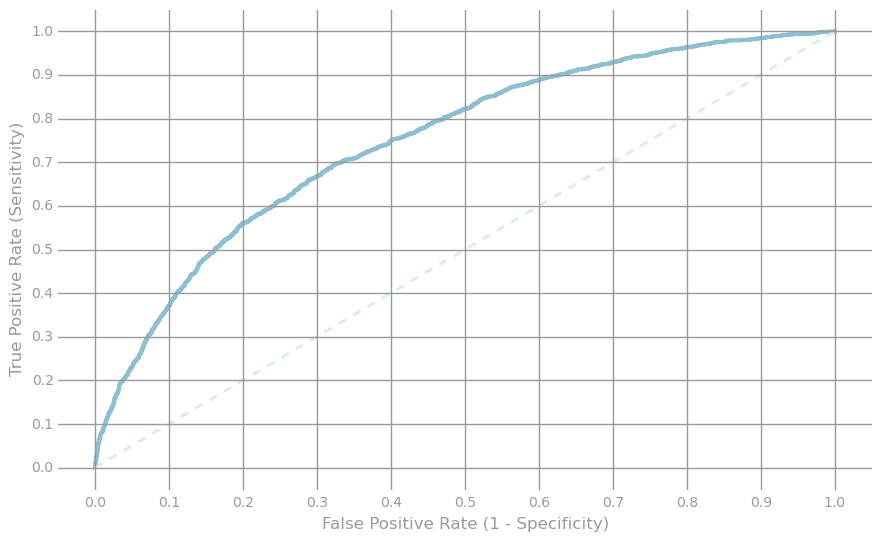

In [27]:
import matplotlib.pyplot as plt
labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

### **Part 3: Reduce feature dimension via feature hashing**

#### ** (3a) Hash function **
#### As we just saw, using a one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed 233K categories in our training data.  Moreover, the full Kaggle training dataset includes more than 33M distinct categories, and the Kaggle dataset itself is just a small subset of Criteo's labeled data.  Hence, featurizing via a one-hot-encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use feature hashing.
####Below is the hash function that we will use for this part of the lab.  We will first use this hash function with the three sample data points to gain some intuition.  Specifically, run code to hash the three sample points using two different values for `numBuckets` and observe the resulting hashed feature dictionaries.

In [28]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

In [29]:
# TODO: Replace <FILL IN> with appropriate code
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
# Use four buckets
sampOneFourBuckets = hashFunction(4, sampleOne, True)
sampTwoFourBuckets = hashFunction(4, sampleTwo, True)
sampThreeFourBuckets = hashFunction(4, sampleThree, True)

# Use one hundred buckets
sampOneHundredBuckets = hashFunction(100, sampleOne, True)
sampTwoHundredBuckets = hashFunction(100, sampleTwo, True)
sampThreeHundredBuckets = hashFunction(100, sampleThree, True)

print '\t\t 4 Buckets \t\t\t 100 Buckets'
print 'SampleOne:\t {0}\t\t {1}'.format(sampOneFourBuckets, sampOneHundredBuckets)
print 'SampleTwo:\t {0}\t\t {1}'.format(sampTwoFourBuckets, sampTwoHundredBuckets)
print 'SampleThree:\t {0}\t {1}'.format(sampThreeFourBuckets, sampThreeHundredBuckets)

{'black1': 2, 'mouse0': 3}
{'cat0': 0, 'tabby1': 0, 'mouse2': 2}
{'bear0': 0, 'black1': 2, 'salmon2': 1}
{'black1': 14, 'mouse0': 31}
{'cat0': 40, 'tabby1': 16, 'mouse2': 62}
{'bear0': 72, 'black1': 14, 'salmon2': 5}
		 4 Buckets 			 100 Buckets
SampleOne:	 {2: 1.0, 3: 1.0}		 {14: 1.0, 31: 1.0}
SampleTwo:	 {0: 2.0, 2: 1.0}		 {40: 1.0, 16: 1.0, 62: 1.0}
SampleThree:	 {0: 1.0, 1: 1.0, 2: 1.0}	 {72: 1.0, 5: 1.0, 14: 1.0}


In [30]:
# TEST Hash function (5a)
Test.assertEquals(sampOneFourBuckets, {2: 1.0, 3: 1.0}, 'incorrect value for sampOneFourBuckets')
Test.assertEquals(sampThreeHundredBuckets, {72: 1.0, 5: 1.0, 14: 1.0},
                  'incorrect value for sampThreeHundredBuckets')

1 test passed.
1 test passed.


#### ** (3b) Creating hashed features **
#### Next we will use this hash function to create hashed features for our CTR datasets. First write a function that uses the hash function with numBuckets = $ \scriptsize 2^{15} \approx 33K $ to create a `LabeledPoint` with hashed features stored as a `SparseVector`.  Then use this function to create new training, validation and test datasets with hashed features. Hint: `parsedHashPoint` is similar to `parseOHEPoint`.

In [31]:
# TODO: Replace <FILL IN> with appropriate code
def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    
    parsedFeat = parsePoint(point)
    
    hashedFeat = hashFunction(numBuckets, parsedFeat)
    
    return LabeledPoint(point[0],SparseVector(numBuckets,hashedFeat)) # len(hashedFeat) is what I used 

numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda point: parseHashPoint(point, numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda point: parseHashPoint(point, numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda point: parseHashPoint(point, numBucketsCTR))
hashTestData.cache()

print hashTrainData.take(1)

[LabeledPoint(0.0, (32768,[1305,2883,3807,4814,4866,4913,6952,7117,9985,10316,11512,11722,12365,13893,14735,15816,16198,17761,19274,21604,22256,22563,22785,24855,25202,25533,25721,26487,26656,27668,28211,29152,29402,29873,30039,31484,32493,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [32]:
# TEST Creating hashed features (5b)
hashTrainDataFeatureSum = sum(hashTrainData
                           .map(lambda lp: len(lp.features.indices))
                           .take(20))
hashTrainDataLabelSum = sum(hashTrainData
                         .map(lambda lp: lp.label)
                         .take(100))
hashValidationDataFeatureSum = sum(hashValidationData
                                .map(lambda lp: len(lp.features.indices))
                                .take(20))
hashValidationDataLabelSum = sum(hashValidationData
                              .map(lambda lp: lp.label)
                              .take(100))
hashTestDataFeatureSum = sum(hashTestData
                          .map(lambda lp: len(lp.features.indices))
                          .take(20))
hashTestDataLabelSum = sum(hashTestData
                        .map(lambda lp: lp.label)
                        .take(100))

Test.assertEquals(hashTrainDataFeatureSum, 772, 'incorrect number of features in hashTrainData')
Test.assertEquals(hashTrainDataLabelSum, 24.0, 'incorrect labels in hashTrainData')
Test.assertEquals(hashValidationDataFeatureSum, 776,
                  'incorrect number of features in hashValidationData')
Test.assertEquals(hashValidationDataLabelSum, 16.0, 'incorrect labels in hashValidationData')
Test.assertEquals(hashTestDataFeatureSum, 774, 'incorrect number of features in hashTestData')
Test.assertEquals(hashTestDataLabelSum, 23.0, 'incorrect labels in hashTestData')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (3c) Sparsity **
#### Since we have 33K hashed features versus 233K OHE features, we should expect OHE features to be sparser. Verify this hypothesis by computing the average sparsity of the OHE and the hashed training datasets.
#### Note that if you have a `SparseVector` named `sparse`, calling `len(sparse)` returns the total number of features, not the number features with entries.  `SparseVector` objects have the attributes `indices` and `values` that contain information about which features are nonzero.  Continuing with our example, these can be accessed using `sparse.indices` and `sparse.values`, respectively.

In [33]:
# TODO: Replace <FILL IN> with appropriate code
def computeSparsity(data, d, n):
    """Calculates the average sparsity for the features in an RDD of LabeledPoints.

    Args:
        data (RDD of LabeledPoint): The LabeledPoints to use in the sparsity calculation.
        d (int): The total number of features.
        n (int): The number of observations in the RDD.

    Returns:
        float: The average of the ratio of features in a point to total features.
    """
    
    int_RDD = data.map(lambda lp: (float(len(lp.features.indices))/d))
    
    return int_RDD.mean()

averageSparsityHash = computeSparsity(hashTrainData, numBucketsCTR, nTrain)
averageSparsityOHE = computeSparsity(OHETrainData, numCtrOHEFeats, nTrain)

print 'Average OHE Sparsity: {0:.7e}'.format(averageSparsityOHE)
print 'Average Hash Sparsity: {0:.7e}'.format(averageSparsityHash)

Average OHE Sparsity: 1.6717677e-04
Average Hash Sparsity: 1.1805561e-03


In [34]:
# TEST Sparsity (5c)
Test.assertTrue(np.allclose(averageSparsityOHE, 1.6717677e-04),
                'incorrect value for averageSparsityOHE')
Test.assertTrue(np.allclose(averageSparsityHash, 1.1805561e-03),
                'incorrect value for averageSparsityHash')

1 test passed.
1 test passed.


#### ** (3d) Logistic model with hashed features **
#### Now let's train a logistic regression model using the hashed features. Run a grid search to find suitable hyperparameters for the hashed features, evaluating via log loss on the validation data. Note: This may take a few minutes to run. Use `1` and `10` for `stepSizes` and `1e-6` and `1e-3` for `regParams`.

In [35]:
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize va"riables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [36]:
hashValidationData.take(1)

[LabeledPoint(0.0, (32768,[2817,3567,3807,5302,5628,5725,6803,7643,7998,8316,9749,10531,10806,11558,11692,11722,11956,12365,12858,13595,13606,16700,17185,17200,19189,19274,21604,22694,24234,24741,25533,25818,28405,28979,31373,31417,32162,32171],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0]))]

In [37]:
# TODO: Replace <FILL IN> with appropriate code
stepSizes = [1,10]
regParams = [1e-6,1e-3]
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(hashTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, hashValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Hashed Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 1.0, regParam = 1e-06: logloss = 0.470
	stepSize = 1.0, regParam = 1e-03: logloss = 0.470
	stepSize = 10.0, regParam = 1e-06: logloss = 0.448
	stepSize = 10.0, regParam = 1e-03: logloss = 0.450
Hashed Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.448


In [38]:
# TEST Logistic model with hashed features (5d)
Test.assertTrue(np.allclose(bestLogLoss, 0.4481683608), 'incorrect value for bestLogLoss')

1 test passed.


#### **Visualization 2: Hyperparameter heat map**
#### We will now perform a visualization of an extensive hyperparameter search.  Specifically, we will create a heat map where the brighter colors correspond to lower values of `logLoss`.
#### The search was run using six step sizes and six values for regularization, which required the training of thirty-six separate models.  We have included the results below, but omitted the actual search to save time.

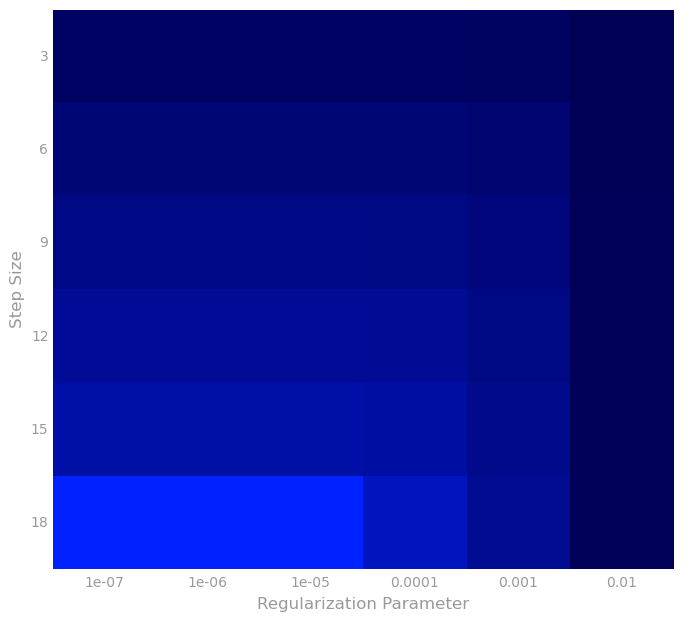

In [39]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results.  Eliminate the time required to run 36 models
stepSizes = [3, 6, 9, 12, 15, 18]
regParams = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
logLoss = np.array([[ 0.45808431,  0.45808493,  0.45809113,  0.45815333,  0.45879221,  0.46556321],
                    [ 0.45188196,  0.45188306,  0.4518941,   0.4520051,   0.45316284,  0.46396068],
                    [ 0.44886478,  0.44886613,  0.44887974,  0.44902096,  0.4505614,   0.46371153],
                    [ 0.44706645,  0.4470698,   0.44708102,  0.44724251,  0.44905525,  0.46366507],
                    [ 0.44588848,  0.44589365,  0.44590568,  0.44606631,  0.44807106,  0.46365589],
                    [ 0.44508948,  0.44509474,  0.44510274,  0.44525007,  0.44738317,  0.46365405]])

numRows, numCols = len(stepSizes), len(regParams)
logLoss = np.array(logLoss)
logLoss.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(stepSizes)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Step Size')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)
pass

#### ** (3e) Evaluate on the test set **
#### Finally, evaluate the best model on the test set.  Compare the resulting log loss with the baseline log loss on the test set, which can be computed in the same way that the validation log loss was computed before.

In [40]:
# TODO: Replace <FILL IN> with appropriate code
# Log loss for the best model from (5d)
logLossTest = evaluateResults(bestModel, hashTestData)

# Log loss for the baseline model
logLossTestBaseline = hashTestData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).mean()

print ('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTestBaseline, logLossTest))

Hashed Features Test Log Loss:
	Baseline = 0.537
	LogReg = 0.456


In [41]:
# TEST Evaluate on the test set (5e)
Test.assertTrue(np.allclose(logLossTestBaseline, 0.537438),
                'incorrect value for logLossTestBaseline')
Test.assertTrue(np.allclose(logLossTest, 0.455616931), 'incorrect value for logLossTest')

1 test passed.
1 test passed.
